<a href="https://colab.research.google.com/github/scriptbuzz/breast_cancer_ml/blob/main/breastcancer_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this repo, I will walk you through the process of building a machine learning pipeline for predicting breast cancer using the Breast Cancer Wisconsin dataset. 

My goal is to classify tumors as either benign or malignant, with a focus on minimizing false negatives (wrongly classifying a malignant tumor as benign) and false positives (wrongly classifying a benign tumor as malignant). 

To achieve this, we will compare the performance of an XGBoost model with other popular models, such as logistic regression, random forest, and support vector machines (SVMs), using common evaluation metrics like accuracy, precision, recall, and F1-score.

Our pipeline will consist of the following steps:

*   Exploratory Data Analysis (EDA): Analyze the dataset to understand its structure, distribution, and relationships between features.

*   Data Ingestion: Loading the Breast Cancer Wisconsin dataset from scikit-learn.

*   Preprocessing: Splitting the dataset into training and testing sets, and scaling the features using StandardScaler to have zero mean and unit variance.

*   Feature Engineering: Selecting the top 10 most important features using the ANOVA F-value to reduce the dimensionality of the dataset and potentially improve model performance.

*   Model Training and Evaluation: Training and evaluating the XGBoost, logistic regression, random forest, and SVM models using the preprocessed and feature-selected dataset. Calculating and comparing their performance using accuracy, precision, recall, and F1-score.

*   Visualization: Visualizing the model performance metrics for comparison and analyzing the feature importances of the XGBoost model to gain insights into the factors contributing to the predictions.

Throughout the tutorial, I will provide detailed explanations of the code, the reasons behind our choices, and visualizations to help you better understand the process. We will use Python and popular machine learning libraries, such as NumPy, pandas, scikit-learn, and XGBoost. 

By the end of this post, you will have a solid understanding of how to build an effective machine learning pipeline for breast cancer prediction and compare the performance of different models using relevant metrics.

In [21]:
# Breast Cancer Prediction Using XGBoost and Comparison with Other Models
# This script demonstrates how to build a machine learning pipeline for predicting breast cancer using the Breast Cancer Wisconsin dataset.
# The pipeline includes data ingestion, preprocessing, feature engineering, model training, evaluation, and visualization.
# We will train an XGBoost model and compare its performance with other popular models, such as logistic regression, random forest, and support vector machines (SVMs), using common evaluation metrics like accuracy, precision, recall, and F1-score.

# Import necessary libraries
import numpy as np  # NumPy: support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions
import pandas as pd  # pandas: data analysis and data manipulation library
import matplotlib.pyplot as plt  # Matplotlib: plotting library
import matplotlib.patches
import seaborn as sns # visualization library
from sklearn.datasets import load_breast_cancer  # Scikit-learn: machine learning library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb  # XGBoost: optimized distributed gradient boosting library



==== target count ====


Number of benign cases: 212
Number of malignant cases: 357


==== dataframe head ====


   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10

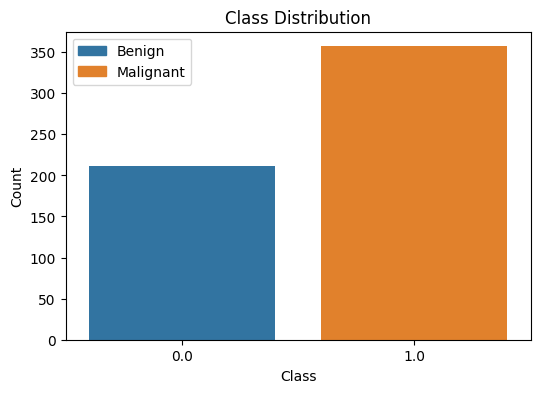

In [22]:
# Load the dataset and create a pandas DataFrame
cancer_data = load_breast_cancer()
data = pd.DataFrame(np.c_[cancer_data['data'], cancer_data['target']], columns=np.append(cancer_data['feature_names'], ['target']))

benign_count = data[data['target'] == 0].shape[0]
malignant_count = data[data['target'] == 1].shape[0]

# Display benign cases vs malignant cases in dataset
print("\n\n==== target count ====\n\n")
print("Number of benign cases:", benign_count)
print("Number of malignant cases:", malignant_count)

# Display the first few rows of the dataset
print("\n\n==== dataframe head ====\n\n")
print(data.head())

# Summary statistics
print("\n\n==== dataframe stats ====\n\n")
print(data.describe())

# Check for missing values
print("\n\n==== dataframe nulls ====\n\n")
print(data.isnull().sum())

# Visualize the distribution of the target variable
'''
The class distribution figure is a bar chart that shows the 
number of instances for each class in the target variable. 
In the context of the Breast Cancer Wisconsin dataset, 
the target variable has two classes: benign (0) and malignant (1). 
The purpose of this visualization is to help you understand 
the distribution of the classes and identify any potential 
class imbalance in the dataset.
'''
# plt.figure(figsize=(6, 4))
# sns.countplot(x='target', data=data)
# plt.title('Class Distribution')
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.show()

# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='target', data=data)

# Adding class labels to the legend
class_labels = ['Benign', 'Malignant']
unique_colors = [ax.patches[0].get_facecolor(), ax.patches[1].get_facecolor()]
legend_patches = [matplotlib.patches.Patch(color=c, label=l) for c, l in zip(unique_colors, class_labels)]

# Display the legend
plt.legend(handles=legend_patches)

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()



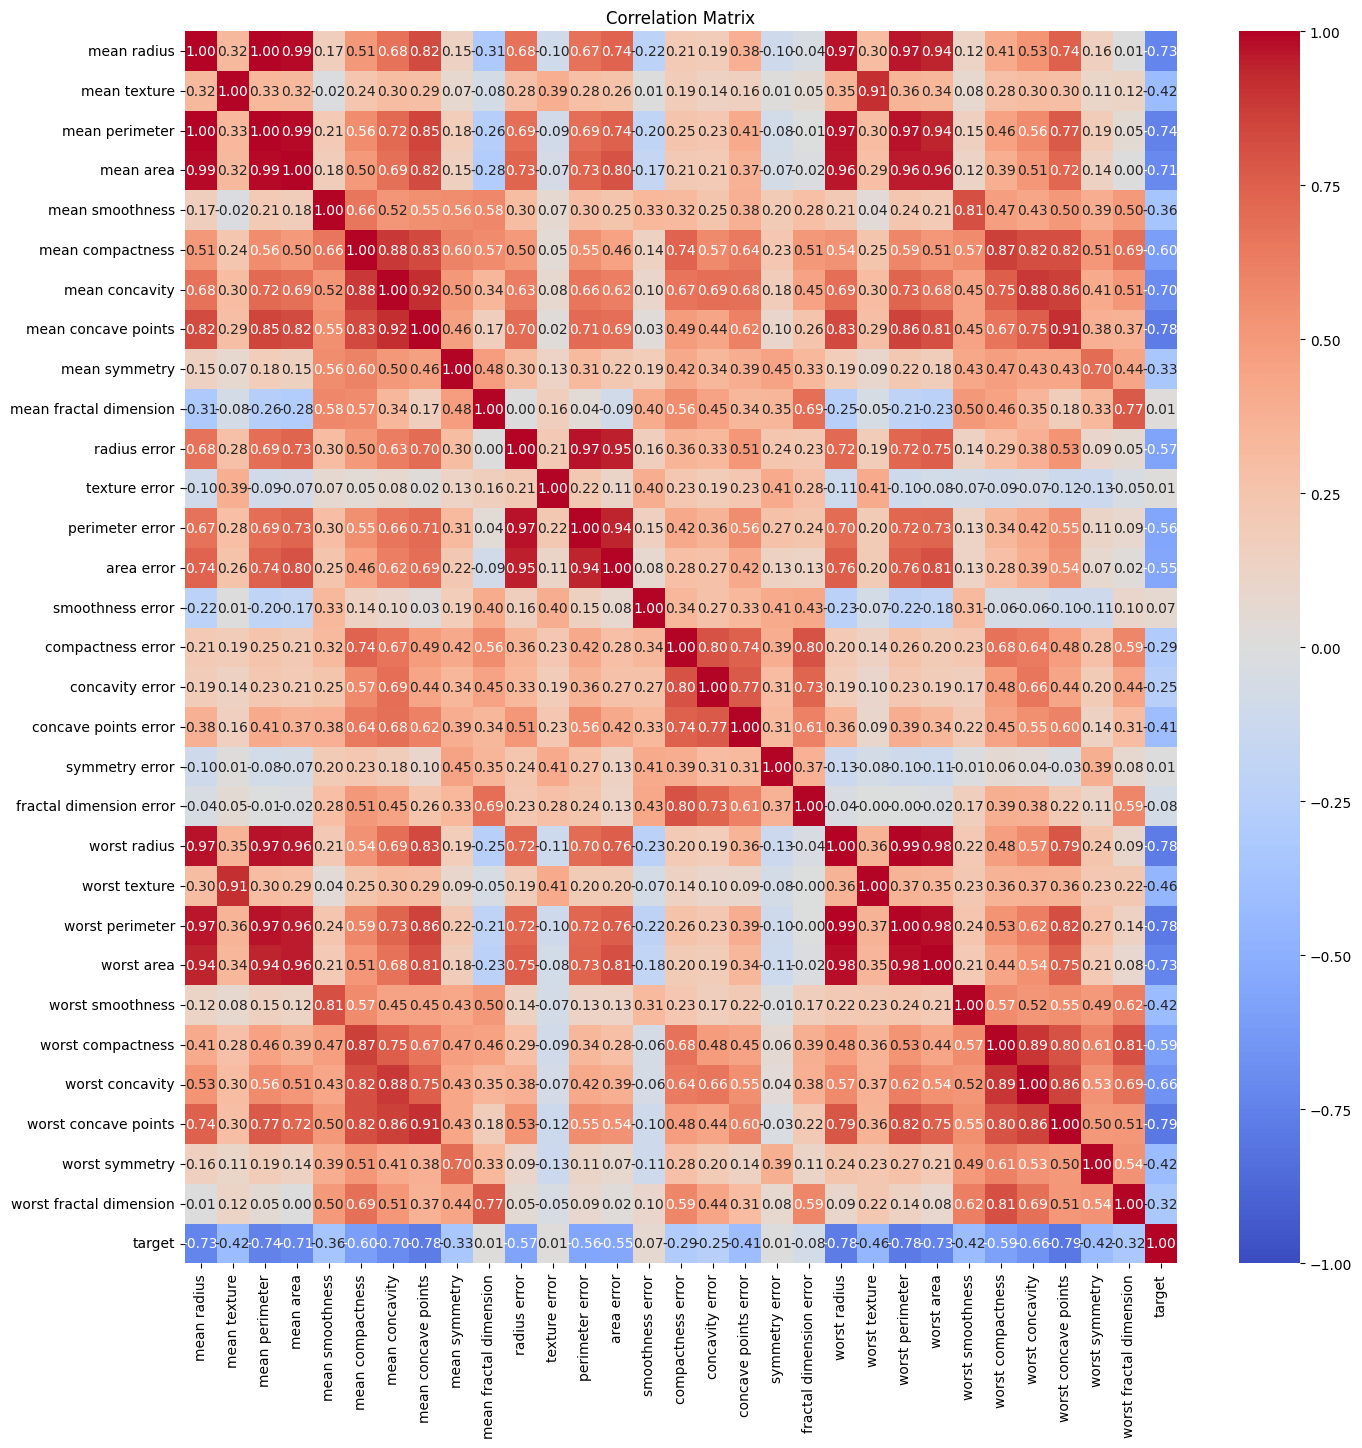

In [23]:
# Correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


Selected features: ['mean radius' 'mean perimeter' 'mean area' 'mean concavity'
 'mean concave points' 'worst radius' 'worst perimeter' 'worst area'
 'worst concavity' 'worst concave points']


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost:
  accuracy: 0.939
  precision: 0.944
  recall: 0.958
  f1: 0.951
Logistic Regression:
  accuracy: 0.974
  precision: 0.986
  recall: 0.972
  f1: 0.979
Random Forest:
  accuracy: 0.956
  precision: 0.958
  recall: 0.972
  f1: 0.965
SVM:
  accuracy: 0.965
  precision: 0.959
  recall: 0.986
  f1: 0.972


<Figure size 1000x500 with 0 Axes>

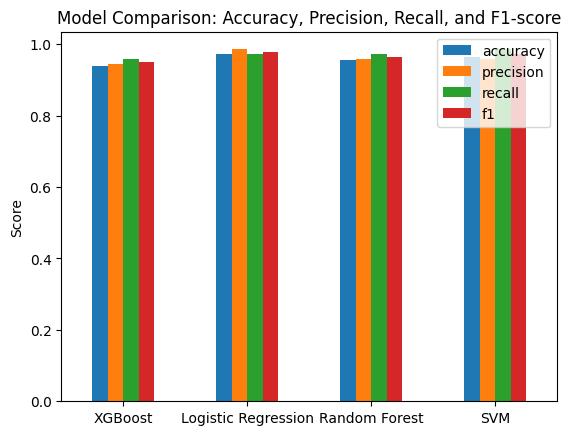

<Figure size 1000x500 with 0 Axes>

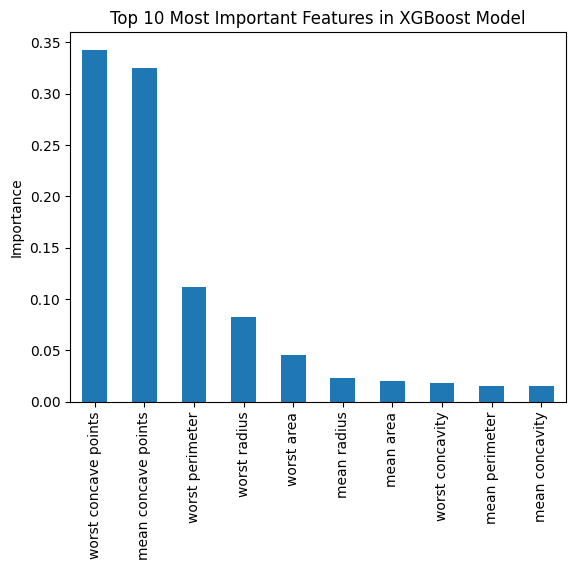

"\nIt's important to note that results can vary depending on factors such as the choice of \nhyperparameters, the dataset split, and the specific implementation of the algorithms.\nI did no fine tuning, yet the results are fairly good. You can tweak the paramaters and \nhypermatameters to improve the results. \n"

In [24]:

# Preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split the dataset into training and testing sets, using an 80-20 split
scaler = StandardScaler()  # Scale the features using StandardScaler to have zero mean and unit variance, which is important for some models such as SVMs and logistic regression
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Engineering
selector = SelectKBest(score_func=f_classif, k=10)  # Select the top 10 most important features using the ANOVA F-value, which can help reduce the dimensionality of the dataset and potentially improve model performance
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)
selected_features = cancer_data.feature_names[selector.get_support()]  # Get the names of the selected features

print("Selected features:", selected_features)


# Model Training and Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lr_model = LogisticRegression()
rf_model = RandomForestClassifier()
svc_model = SVC()

models = [xgb_model, lr_model, rf_model, svc_model]
model_names = ['XGBoost', 'Logistic Regression', 'Random Forest', 'SVM']
results = {}

for model, name in zip(models, model_names):
    accuracy, precision, recall, f1 = evaluate_model(model,X_train_selected, y_train, X_test_selected, y_test)
    results[name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Print the evaluation metrics for each model
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.3f}")

# Visualization of Model Evaluation Metrics
metrics_df = pd.DataFrame(results).T
plt.figure(figsize=(10, 5))
metrics_df.plot(kind='bar', legend=True)
plt.title('Model Comparison: Accuracy, Precision, Recall, and F1-score')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

# Visualization of Feature Importances
feature_importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'importance': feature_importances}, index=selected_features)
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 5))
importance_df.plot(kind='bar', legend=False)
plt.title('Top 10 Most Important Features in XGBoost Model')
plt.ylabel('Importance')
plt.show()

'''
It's important to note that results can vary depending on factors such as the choice of 
hyperparameters, the dataset split, and the specific implementation of the algorithms.
I did no fine tuning, yet the results are fairly good. You can tweak the paramaters and 
hypermatameters to improve the results. 
'''


Choosing the most relevant performance metric depends on the problem you are trying to solve and the specific context of the dataset. In the case of the Breast Cancer Wisconsin dataset, where the goal is to predict whether a tumor is benign or malignant, we want to minimize false negatives (i.e., wrongly classifying a malignant tumor as benign) and false positives (i.e., wrongly classifying a benign tumor as malignant). Depending on the relative importance of these errors, different metrics may be more relevant:

*   Accuracy: The proportion of correct predictions among the total number of predictions. This metric is useful when the classes are balanced and the costs of false positives and false negatives are similar. However, it can be misleading when the dataset is imbalanced or when there is a difference in the importance of false positives and false negatives.

*   Precision: The proportion of true positive predictions among all positive predictions. It measures how many of the predicted positive instances are actually positive. This metric is more relevant when the cost of false positives is high.

*   Recall (Sensitivity): The proportion of true positive predictions among all actual positive instances. It measures how many of the actual positive instances are captured by the positive predictions. This metric is more relevant when the cost of false negatives is high.

*   F1-score: The harmonic mean of precision and recall. This metric balances both precision and recall and is useful when the costs of false positives and false negatives are similar and both are important. It is particularly relevant when the dataset is imbalanced.

In the context of breast cancer prediction, false negatives (failing to identify a malignant tumor) may have more severe consequences than false positives (falsely identifying a benign tumor as malignant). Therefore, recall could be considered a more relevant performance metric in this case. However, it's important to consider the trade-offs between precision and recall, as well as the specific context of your application, when selecting the most relevant performance metric.

Thank you. 